# Detection of Malicicous Data

## Part I: Preprocessing 

### Read the data.file
The data file includes dataset structured like Basic Safety Messages (BSM) defined in the SEA J2735 standard, including vehicle's location, speed, acceleration, heading, and brake status. We utilize the data to check the correcteness of the data and better classify the five types of position spoofing attack. 

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

### colunm data
1. Type (3=BSM)
2. Time BSM was received by the receiver
3. Receiver ID
4. Receiver X position
5. Receiver Y position
6. Receiver Z position
7. Time BSM was transmitted
8. Transmitter ID
9. BSM ID
10. Transmitter X position
11. Transmitter Y position
12. Transmitter Z position
13. Transmitter X velocity
14. Transmitter Y velocity
15. Transmitter Z velocity
16. RSSI (Received Signal Strength Indicator)
17. Label (0=Normal Behavior)

In [3]:
cols = [2,3,4,9,10,15,16] #id, xr ,yr, xt, yt, RSSI, label.
data = pd.read_csv("dataset/attack1withlabels.csv",usecols=cols)
data = data.dropna(axis=0, how="any")#remove invalid data
data_id = data.iloc[:,0]
# attack 1: distance is too far recevier and transmitter
pos_xr = data.iloc[:,1]
pos_yr = data.iloc[:,2]
pos_xt = data.iloc[:,3]
pos_yt = data.iloc[:,4]
rssi   = data.iloc[:,5]
label = data.iloc[:,6]


In [4]:
# We read the data from the dataset.
data = pd.read_csv("dataset/attack1withlabels.csv", usecols=cols, header=None)
X = data.iloc[:,:6]
y = data.iloc[:,6]

Two observations for attack 1
* The fake distance exceed the upper bound of communication range which is 800m
* The distance does not change but the RSSI changes.
The first criteria is trivial, thus we apply a filter. 

In [5]:
#add a distance feature
def distance(X):
    distance = np.zeros(len(X))
    for i in range(len(X)):
        distance[i] = np.linalg.norm([X.iloc[i][3]-X.iloc[i][9], X.iloc[i][4]-X.iloc[i][10]])
    distance_series = pd.Series(distance)
    return distance_series

distance_series = distance(X)
X['distance'] = distance_series

In [36]:
# We filter the BSM whose distance is above the thredhold = 800
def filtering_dis(X,y,thredhold):
    drop_index = np.zeros(len(y))
    for i in range(len(y)):
        if X['distance'][i] > thredhold:
            drop_index[i]=1
    return drop_index
drop_index = filtering_dis(X,y,800)
drop_index_ = np.where(drop_index>0)
np.asarray(drop_index_)[0]
X_filter = X.drop(np.asarray(drop_index_)[0])
y_filter = y.drop(np.asarray(drop_index_)[0])

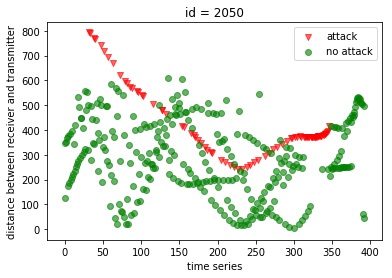

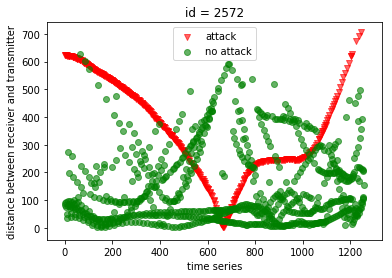

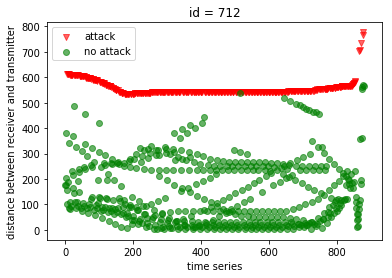

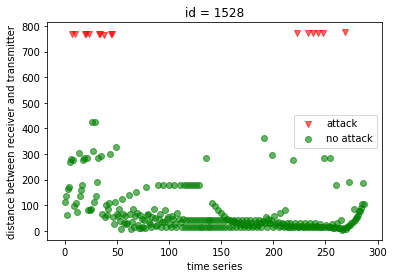

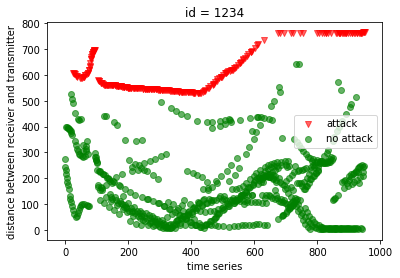

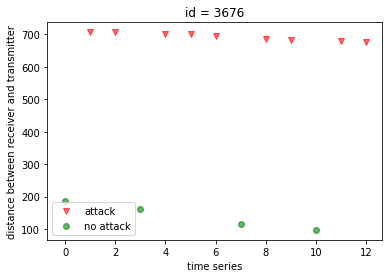

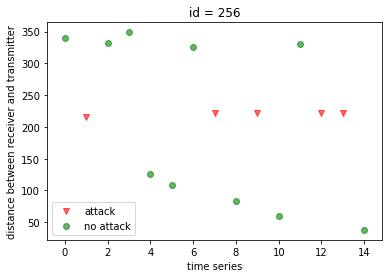

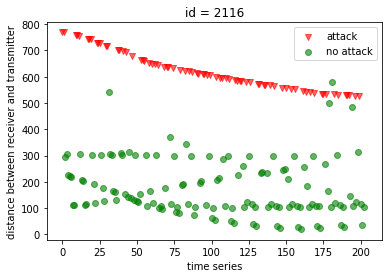

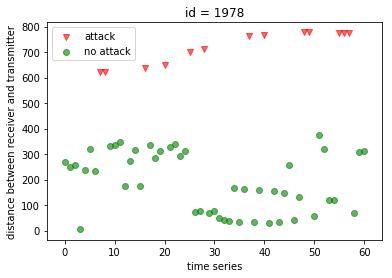

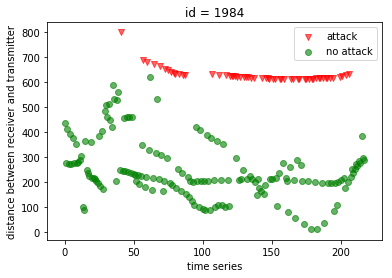

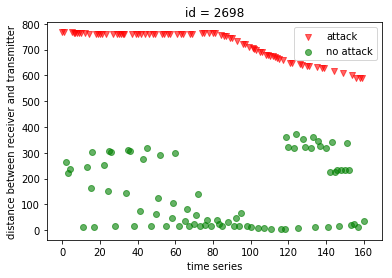

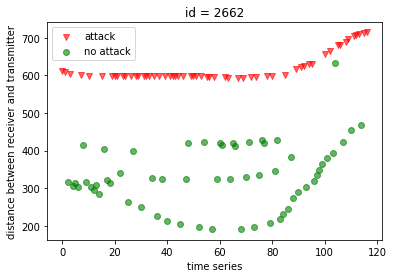

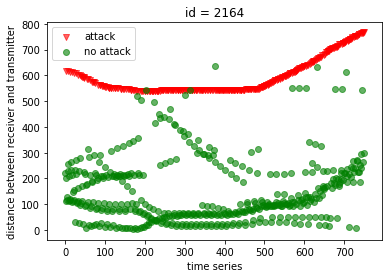

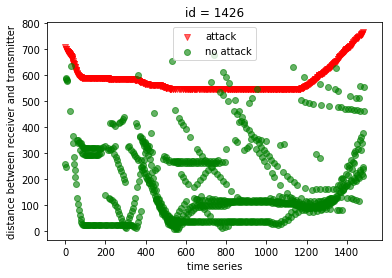

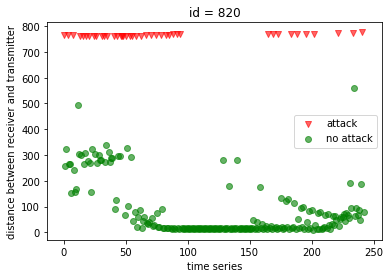

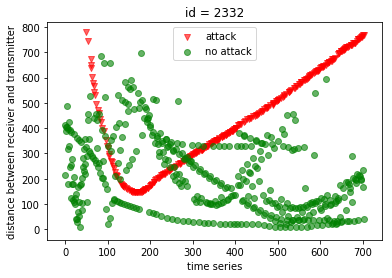

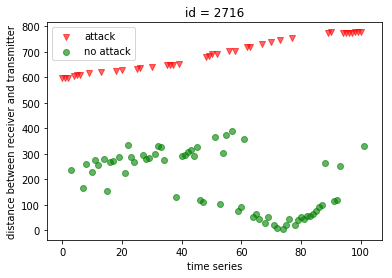

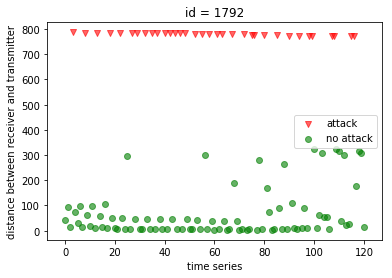

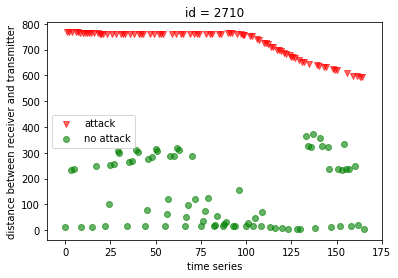

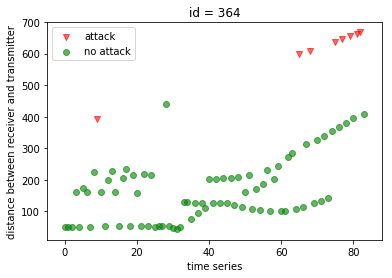

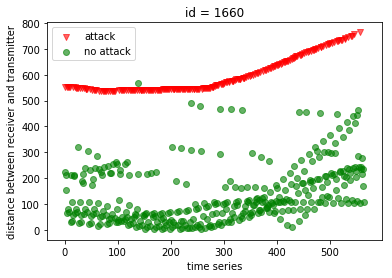

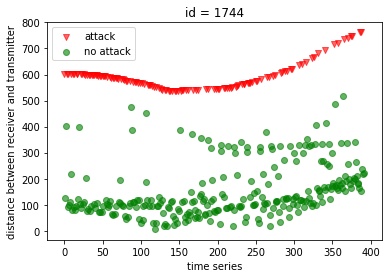

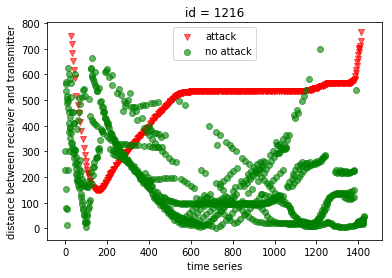

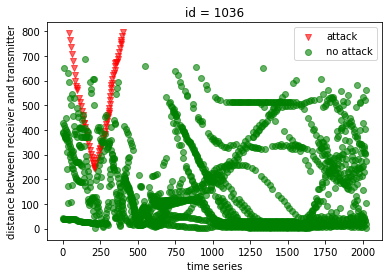

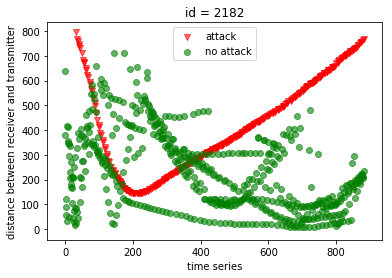

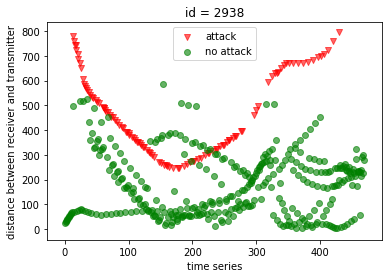

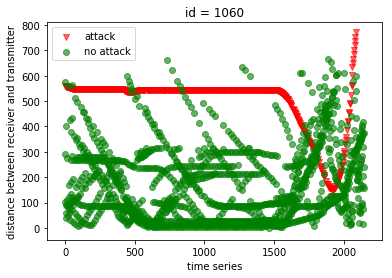

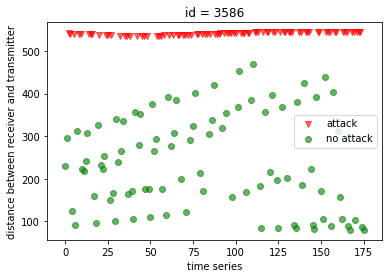

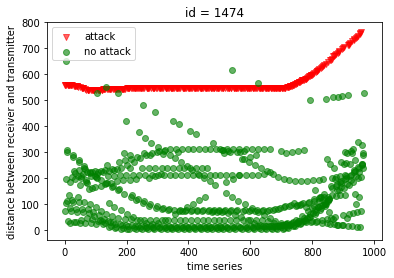

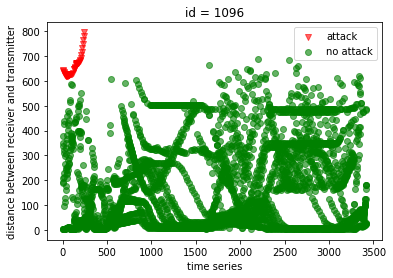

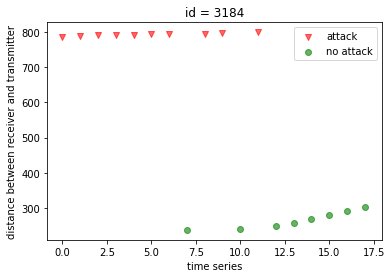

In [42]:
#display figure of distance and attack(no attack)
def cal_dis(x1,y1,x2,y2):
    return np.linalg.norm([x1-x2, y1-y2])
def display_dist_attack(data_frame_X, data_frame_y):
    #display the feature
    data_id=data_frame_X[2]
    pos_xr = data_frame_X[3].values
    pos_yr = data_frame_X[4].values
    pos_xt = data_frame_X[9].values
    pos_yt = data_frame_X[10].values
    label  = data_frame_y.values
    index = 0
    for i in range(100): # for example , we take the case of id 0-40
        x=[]
        y=[]
        attack = []
        no_attack =[]
        a = data_id.values[index]
        count = data_id.value_counts()[a]
        tm = np.arange(0,count)
        for j in range(count):
            dis = cal_dis(pos_xr[j+index],pos_yr[j+index],pos_xt[j+index],pos_yt[j+index])
            if(label[j+index]==1):
                attack.append([j,dis])
            else:
                no_attack.append([j,dis])
        #transpose
        attack_l = []
        no_attack_l =[]
        for row in attack :
            attack_l= [[attack[j][i] for j in range(len(attack))] for i in range(len(attack[0]))]
        for row in no_attack:
            no_attack_l = [[no_attack[j][i] for j in range(len(no_attack))] for i in range(len(no_attack[0]))]

        index = index + count
        
        if(len(attack_l)!=0):
            fig = plt.figure(i)
            if(len(attack_l)==0):
                attack_l=[]
            else:
                plt.scatter(attack_l[0],attack_l[1],c='red',marker='v',alpha=0.6,label='attack')
            if(len(no_attack_l)==0):
                no_attack_l=[]
            else:
                plt.scatter(no_attack_l[0],no_attack_l[1],c="green",alpha=0.6,label="no attack")

            plt.xlabel("time series")
            plt.ylabel("distance between receiver and transmitter")
            plt.legend(loc="best")
            plt.title("id = "+str(a))
            plt.show()
display_dist_attack(X_filter,y_filter)

In [111]:
len(X_filter[2].values)

333003

In [117]:
def cal_count_id(X_train):
    tmp = 0
    batch_size =0
    list_batch_size = []
    for i in range(len(X_train[2].values)):
        if(X_train[2].values[i] == tmp):
            batch_size =batch_size+1;
        else: 
            print(batch_size)
            list_batch_size.append(batch_size)
            batch_size=1
        tmp = X_train[2].values[i]
    return list_batch_size[1:]

In [118]:
def drop_no_attack(data_frame_X, data_frame_y):
    #display the feature
    data_id= data_frame_X[2]
    pos_xr = data_frame_X[3].values
    pos_yr = data_frame_X[4].values
    pos_xt = data_frame_X[9].values
    pos_yt = data_frame_X[10].values
    label  = data_frame_y.values
    list_to_drop = []
    index = 0
    for i in range(len(cal_count_id(data_frame_X))): # for example , we take the case of id 0-40
        x=[]
        y=[]
        attack = []
        no_attack =[]
        a = data_id.values[index]
        count = data_id.value_counts()[a]
        tm = np.arange(0,count)
        for j in range(count):
            dis = cal_dis(pos_xr[j+index],pos_yr[j+index],pos_xt[j+index],pos_yt[j+index])
            if(label[j+index]==1):
                attack.append([j,dis])
            else:
                no_attack.append([j,dis])
        #transpose
        attack_l = []
        no_attack_l =[]
        for row in attack :
            attack_l= [[attack[j][i] for j in range(len(attack))] for i in range(len(attack[0]))]
        for row in no_attack:
            no_attack_l = [[no_attack[j][i] for j in range(len(no_attack))] for i in range(len(no_attack[0]))]
        
        start = index
        index = index + count
                    
        if(len(attack_l)==0):
            for m in range(start,index+1):
                list_to_drop.append(m)
    return list_to_drop  
index_to_drop = drop_no_attack(X_filter,y_filter)

0
3
495
393
399
327
217
225
2
472
367
402
432
319
1257
880
862
322
288
289
951
392
291
248
296
213
490
425
13
25
196
15
203
898
385
61
218
161
450
536
117
609
1101
420
1408
751
459
1485
243
240
705
102
195
411
493
984
121
166
528
260
430
301
84
543
1765
377
508
237
310
226
428
258
565
434
392
1427
306
2022
424
884
625
881
66
470
508
2144
527
176
192
424
967
455
336
371
473
454
251
420
3423
224
18
58
545
996
355
703
61
284
516
434
415
333
113
382
104
88
9
455
460
1217
870
1679
85
1085
347
858
1840
395
378
579
81
367
429
1343
274
1075
397
2
151
72
255
105
144
434
1822
386
241
469
1883
112
250
951
1156
228
69
382
922
71
486
411
82
1281
884
633
61
534
376
434
91
2754
360
595
210
379
37
535
238
858
1165
439
243
1048
1220
488
451
449
273
1497
206
70
259
717
783
380
40
3
258
213
448
1952
422
490
275
205
208
488
883
121
1220
100
336
6
164
127
327
429
440
152
475
77
302
461
3020
469
106
295
62
1103
274
839
132
1716
41
473
126
986
3
263
166
328
670
178
345
48
552
1908
1025
285
257
1672
420
2491


In [120]:
#drop receiver colums 
#X_feed = X_filter.drop([3, 4], axis = 1)
#drop no attack to avoid too much no_attack which could improve the percent of attack 
X_filter.index = range(len(X_filter))
y_filter.index = range(len(y_filter))
X_feed =X_filter.drop(index_to_drop)
y_feed =y_filter.drop(index_to_drop)



In [121]:
# split training data and validate data
data_count = y_feed.count()
data_rate = 0.8 * data_count
data_rate = int(data_rate)
X_train = X_feed.iloc[:data_rate,:]
y_train = y_feed.iloc[:data_rate]
X_test = X_feed.iloc[data_rate:,:]
y_test = y_feed.iloc[data_rate:]

print('X_train shape ',X_train.shape)
print('y_train shape ',y_train.shape)

X_train shape  (113700, 7)
y_train shape  (113700,)


After pre-processing, we get the following relevant information:
1. The ID of the transmitter BSM (Coloum 2)
2. Transmitter positions (Coloum 9,10)
3. The distance between transmitter and receiver (Coloum 'distance')
4. The RSSI (Coloum 16)
We feed the following information into the training model.

## impletation keras

In [122]:
from tensorflow.python.keras import backend as k
from keras.models import Sequential
from keras.layers import Dense,Activation
from keras.layers.recurrent import LSTM
import tensorflow
from sklearn import model_selection


In [136]:
# model implementation
model = Sequential()
model.add(LSTM(32, input_shape=(None,7),return_sequences=False))
model.add(Dense(8, input_dim=7))
model.add(Dense(1, activation="relu"))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [137]:
print("The radio of attack/all = ",sum(y_train)/y_train.shape[0])
X_train.index = range(len(X_train))
y_train.index = range(len(y_train))

The radio of attack/all =  0.3217941952506596


In our dataset, attack take the part of 14% and normal take a part of 86% 

In [138]:
itr = 0
def cal_count_id(X_train):
    tmp = 0
    batch_size =0
    list_batch_size = []
    for i in range(len(X_train[2].values)):
        if(X_train[2].values[i] == tmp):
            batch_size =batch_size+1;
        else: 
            list_batch_size.append(batch_size)
            batch_size=1
        tmp = X_train[2].values[i]
    return list_batch_size[1:]
itr = cal_count_id(X_train)

In [139]:
#to satisfait LSTM
X_train = np.reshape(X_train.values, (X_train.shape[0], 1,X_train.shape[1]))
X_test =np.reshape(X_test.values, (X_test.shape[0], 1, X_test.shape[1]))

In [140]:
#fit data
start = 0
stop = 0
for i in range(len(itr)):
    start = stop
    stop =itr+start
    model.fit(X_train[start,stop],y_train[start,stop],epochs=1,batch_size=itr[i])
#Because all the time, the count of id is different, so how could we do to train the data?

Epoch 1/1
113700/113700 [==============================] - 3s 24us/step - loss: 0.6606 - acc: 0.6455
Epoch 1/1
113700/113700 [==============================] - 1s 12us/step - loss: 0.3953 - acc: 0.7713
Epoch 1/1
113700/113700 [==============================] - 2s 13us/step - loss: 0.3181 - acc: 0.8824
Epoch 1/1
113700/113700 [==============================] - 2s 14us/step - loss: 0.4806 - acc: 0.7843
Epoch 1/1
113700/113700 [==============================] - 2s 17us/step - loss: 0.6104 - acc: 0.6782
Epoch 1/1
113700/113700 [==============================] - 27s 233us/step - loss: 3.0281 - acc: 0.6716
Epoch 1/1
 11550/113700 [==>...........................] - ETA: 20s - loss: 5.1410 - acc: 0.6810

KeyboardInterrupt: 

In [125]:
cost = model.evaluate(X_test.values,y_test.values,batch_size=100)
print('loss \n',cost[0])
print('accurency \n',cost[1])

66601/66601 [==============================] - 1s 8us/step
loss 
 1.8329824162138717
accurency 
 0.8862779837549901
